# ML Assignment 7

------

**Design a Naïve Bayes classifier for filtering Spam and Ham (Normal) messages. Make a comparative study on the performance of all the three models of Naïve Bayes classifier.** 

1) **[Gaussian](#Gaussian-NB):** For features following a normal distribution.<br/>
2) **[Multinomial](#Multinomial-NB):** For discrete counts.<br/>
3) **[Bernoulli](#Bernoulli-NB):** for binary feature vectors

**The SMS data set together with readme file is from UCI Machine Learning Repository.**

------

### Importing the Required hearder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import string

------
### Loading Data

In [2]:
sms = pd.read_csv('SMSSpamCollection.csv', sep='\t')
sms['label'].replace({"ham": 0, "spam": 1}, inplace=True)
sms.head(5)

,label,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


------
### Randomize the data

In [3]:
data_randomized = sms.sample(frac=1, random_state=1)

train_test_index = round(len(data_randomized) * 0.8)

train_set = data_randomized[:train_test_index].reset_index(drop=True)
test_set = data_randomized[train_test_index:].reset_index(drop=True)

print(train_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


------
### Distribution of Original, Train and Test set.

In [4]:
print('ORIGINAL SET : ')
print(sms['label'].value_counts(normalize=True))
print('\n\nTRAIN SET : ')
print(train_set['label'].value_counts(normalize=True))
print('\n\nTEST SET : ')
print(test_set['label'].value_counts(normalize=True))

ORIGINAL SET : 
0    0.865937
1    0.134063
Name: label, dtype: float64


TRAIN SET : 
0    0.86541
1    0.13459
Name: label, dtype: float64


TEST SET : 
0    0.868043
1    0.131957
Name: label, dtype: float64


------
### Data Preprocessing

#### Removing punctiations and caps

In [5]:
print('Before change : \n')
train_set.head(5)

Before change : 



,label,Text
0,0,"Yep, by the pretty sculpture"
1,0,"Yes, princess. Are you going to make me moan?"
2,0,Welp apparently he retired
3,0,Havent.
4,0,I forgot 2 ask ü all smth.. There's a card on ...


In [6]:
train_set['Text'] = train_set['Text'].str.replace('\W', ' ')
train_set['Text'] = train_set['Text'].str.lower()
train_set.head(5)

,label,Text
0,0,yep by the pretty sculpture
1,0,yes princess are you going to make me moan
2,0,welp apparently he retired
3,0,havent
4,0,i forgot 2 ask ü all smth there s a card on ...


#### Making the dictionary (containing the words)

In [7]:
words = []
train_set['Text'] = train_set['Text'].str.split()

for i in train_set['Text']:
    for j in i:
        words.append(j)

words = list(set(words)) # making the words unique and sorted

print('Number of Unique words in the dataset : ', len(words))

Number of Unique words in the dataset :  7783


In [8]:
f = {w: [0] * len(train_set['Text']) for w in words}

for i, text in enumerate(train_set['Text']):
    for word in text:
        f[word][i] += 1

In [9]:
word_counts = pd.DataFrame(f)
word_counts.head()

,terrorist,europe,jane,09111030116,athletic,road,100p,causing,appeal,tv,...,waaaat,ericsson,greatest,100percent,09064012160,prediction,pm,html,first,60
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Final dataset to be used

In [10]:
train_set_new = pd.concat([train_set, word_counts], axis=1)
train_set_new.head()

,label,Text,terrorist,europe,jane,09111030116,athletic,road,100p,causing,...,waaaat,ericsson,greatest,100percent,09064012160,prediction,pm,html,first,60
0,0,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print(train_set_new[['yep', 'by', 'the', 'pretty', 'sculpture']].iloc[[0]])

   yep  by  the  pretty  sculpture
0    1   1    1       1          1


------
## Multinomial NB

### Training the Model 

#### Calculating the required constants

In [12]:
# Splitting spam and ham messages first
spam_messages = train_set_new[train_set_new['label'] == 1]
ham_messages = train_set_new[train_set_new['label'] == 0]

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(train_set_new)
p_ham = len(ham_messages) / len(train_set_new)

# N_Spam
n_spam = spam_messages['Text'].apply(len).sum()

# N_Ham
n_ham = ham_messages['Text'].apply(len).sum()

# N_Words -> in the dictonary
n_words = len(words)

# Laplace smoothing
alpha = 1

#### Calculating the required Parameters

<img src="https://latex.codecogs.com/gif.latex?\boldsymbol{\mathbf{P(w_i|Spam)%20=%20\frac{N_{w_i|Spam}%20+%20\alpha}{N_{Spam}%20+%20\alpha%20\cdot%20N_{Vocabulary}}}}" align='left'>
<br/><br/><br/><br/>
<img src="https://latex.codecogs.com/gif.latex?\boldsymbol{\mathbf{P(w_i|Ham)%20=%20\frac{N_{w_i|Ham}%20+%20\alpha}{N_{Ham}%20+%20\alpha%20\cdot%20N_{Vocabulary}}}}" align='left'>

In [13]:
# Initiate parameters
probs_spam = {w:0 for w in words}
probs_ham = {w:0 for w in words}

# Calculate parameters
for w in words:
    n_wi_given_spam = spam_messages[w].sum() # spam_messages already defined
    p_wi_given_spam = (n_wi_given_spam + alpha) / (n_spam + alpha*n_words)
    probs_spam[w] = p_wi_given_spam

    n_wi_given_ham = ham_messages[w].sum() # ham_messages already defined
    p_wi_given_ham = (n_wi_given_ham + alpha) / (n_ham + alpha*n_words)
    probs_ham[w] = p_wi_given_ham

------
### Testing the datasets

<img src="https://latex.codecogs.com/gif.latex?\boldsymbol{\mathbf{P(Spam%20|%20w_1,w_2,%20...,%20w_n)%20\propto%20P(Spam)%20\cdot%20\prod_{i=1}^{n}P(w_i|Spam)}}" align="left">
<br/><br/><br/><br/>
<img src="https://latex.codecogs.com/gif.latex?\boldsymbol{\mathbf{P(Ham%20|%20w_1,w_2,%20...,%20w_n)%20\propto%20P(Ham)%20\cdot%20\prod_{i=1}^{n}P(w_i|Ham)}}" align="left">

In [14]:
def predict(text):
    # remove punctuations and convert to lower case
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    
    # split into array
    text = text.split(' ')
    
    p_spam_text = p_spam
    p_ham_text = p_ham
    
    for w in text:
        if w in probs_spam:
            p_spam_text *= probs_spam[w]
        if w in probs_ham:
            p_ham_text *= probs_ham[w]

    if p_spam_text > p_ham_text:
        return 1
    elif p_ham_text > p_spam_text:
        return 0
    else:           # Equally likely
        return -1

------
### Results

In [15]:
prediction_MNB = []
for text in test_set['Text']:
    prediction_MNB.append(predict(text))

prediction_MNB = np.array(prediction_MNB)
label_test = test_set['label'].to_numpy()
print('Test set accuracy = ', (np.sum(label_test == prediction_MNB)/len(prediction_MNB)) * 100)

Test set accuracy =  98.1149012567325


------
## Bernoulli NB

###  Training the Model 

####  Calculating the required constants

In [16]:
# Splitting spam and ham messages first
spam_messages = train_set_new[train_set_new['label'] == 1].to_numpy()
ham_messages = train_set_new[train_set_new['label'] == 0].to_numpy()

# converting data to bernoulli (0, 1)
spam_messages[:, 2:] = 1*(spam_messages[:, 2:] >= 1)
ham_messages[:, 2:] = 1*(ham_messages[:, 2:] >= 1)

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(train_set_new)
p_ham = len(ham_messages) / len(train_set_new)

#### Calculating the required Parameters

In [17]:
# Initiate parameters
probs_spam = {w:0 for w in words}
probs_ham = {w:0 for w in words}

ham_val = np.sum(ham_messages[:, 2:], axis = 0) / len(ham_messages)
spam_val = np.sum(spam_messages[:, 2:], axis = 0) / len(spam_messages)

i = 0
for w in words:
    probs_spam[w] = spam_val[i]
    probs_ham[w] = ham_val[i]
    i += 1

### Results

In [18]:
prediction_BNB = []
for text in test_set['Text']:
    prediction_BNB.append(predict(text))

prediction_BNB = np.array(prediction_BNB)
label_test = test_set['label'].to_numpy()
print('Test set accuracy = ', (np.sum(label_test == prediction_BNB)/len(prediction_BNB)) * 100)

Test set accuracy =  91.47217235188509


------
## Gaussian NB

### Utility functions

In [45]:
def calc_phi(Y):
    m = len(Y)
    return (m-np.sum(Y))/m, np.sum(Y)/m


def calc_mu(X):
    M = np.mean(X, axis=0)
    return M


def calc_sigma(X, mu):
    m = X.shape[0]
    
    res = np.dot((X-mu).T, (X-mu))
    
    return res/m


def calc_p_x_y(X, mu, sigma):
    c = 1 / (((2*np.pi)**(5/2))*np.sqrt(np.linalg.det(sigma)))
    
    return c*np.exp((-0.5)*np.dot(np.dot((X-mu), (np.linalg.inv(sigma))), (X-mu).T))


def predict_G(X, mu_0, mu_1, phi_0, phi_1, sigma):
    m = X.shape[0]
    
    pX_0 = np.dot(calc_p_x_y(X, mu_0, sigma), np.ones((m, 1))*phi_0)
    pX_1 = np.dot(calc_p_x_y(X, mu_1, sigma), np.ones((m, 1))*phi_1)
    
    return 1*(pX_0 < pX_1) == Y_test

###  Training the Model 

####  Calculating the required constants

**NOTE : Takes too long to calculate sigma, uncomment if you want to run**

In [44]:
# X_train_1 = train_set_new[train_set_new['label'] == 1].to_numpy()
# X_train_0 = train_set_new[train_set_new['label'] == 0].to_numpy()

# phi_0, phi_1 = calc_phi(train_set['label'].to_numpy())
# mu_0 = calc_mu(X_train_0[:, 2:])
# mu_1 = calc_mu(X_train_1[:, 2:])
# sigma = calc_sigma(X_train_1[:, 2:], mu_1)

### Results

In [43]:
# Y_pred = predict_G(train_set['label'].to_numpy(), mu_0, mu_1, phi_0, phi_1, sigma)

# print("Test set accuracy = ", 100*(np.sum(Y_pred) / X_test.shape[0]))

------
## Final Results

| Model | Accuracy(%) |
| :- | :-: |
| Multinomial Naive Bayers | 98.115 |
| Bernoulli Naive Bayers | 91.472 |
| Gaussian Naive Bayers | 90.365 |

### Confusion Matrices

In [23]:
def CM(Y_test, T_test_pred):
    n = Y_test.shape[0]
    TP = FP = FN = TN = 0
    for i in range(n):
        if T_test_pred[i] == 1 and Y_test[i] == 1:
            TP += 1
        elif T_test_pred[i] == 1 and Y_test[i] == 0:
            FP += 1
        elif T_test_pred[i] == 0 and Y_test[i] == 1:
            FN += 1
        else:
            TN += 1
            
    return TP, FP, FN, TN

In [24]:
TP_M, FP_M, FN_M, TN_M = CM(label_test, prediction_MNB)
TP_B, FP_B, FN_B, TN_B = CM(label_test, prediction_BNB)

print(TP_M, FP_M, FN_M, TN_M)
print(TP_B, FP_B, FN_B, TN_B)

132 6 15 961
108 19 7 980


### ROC Curves

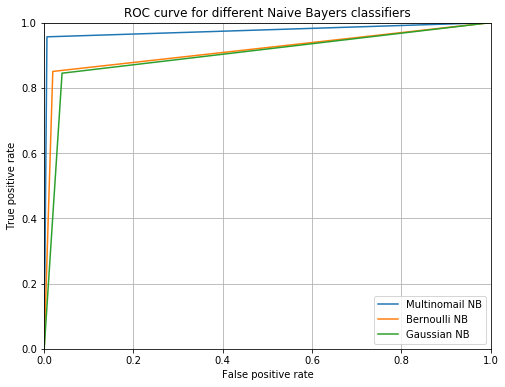

In [73]:
plt.figure(figsize=(8, 6))
plt.plot([0, (FP_M/ (FN_M+TN_M)), 1],[0, (TP_M/(TP_M+FP_M)), 1])
plt.plot([0, (FP_B/ (FN_B+TN_B)), 1],[0, (TP_B/(TP_B+FP_B)), 1])
plt.plot([0, 0.04, 1],[0, 0.845, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for different Naive Bayers classifiers')
plt.legend(['Multinomail NB', 'Bernoulli NB', 'Gaussian NB'], loc = 'lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid(True)